# PopStar Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the PopStar package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation with all the available options to the user at each step is provided in [XXX].

Before starting this tutorial, it is assumed that PopStar has been installed and the user's python path has been altered to include the PopStar top-level directory

In [42]:
# Import necessary packages. 
from popstar import synthetic, evolution, atmospheres, reddening
from popstar.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb

#### Step 1: Make a PopStar isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth.

In [43]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec

# Define evolution/atmosphere models and extinction law (optional)
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (not shown here; default location is current working directory). In the future, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The file name will be the following: "iso_logAge_AKs_distance.fits, using the specified values

In [44]:
# The individual points in the isochrone can be accessed using the points subfunction 
# on the isochrone object. This produces an astropy table that contains the 
# list of stellar masses in the isochrone and their associated properties
print(my_iso.points)

        L              Teff           R       ...  m_hst_f139m   m_hst_f153m 
        W               K             m       ...                            
----------------- ------------- ------------- ... ------------- -------------
 6.6223065394e+24 2928.19503557 355544441.991 ...  22.421444684 21.6786173741
7.16488591987e+24 2943.74373371 365926527.138 ... 22.3331662976 21.5907520715
7.79846773928e+24 2958.69365251 377914794.572 ... 22.2391257757 21.4969895022
8.33507054524e+24 2975.08925888 386406028.983 ... 22.1649180532 21.4232916242
8.87174968782e+24 2992.26463661 394088619.943 ... 22.0956762438 21.3545946148
8.90244460341e+24 3009.53916887 390250882.621 ... 22.0906403072 21.3511116584
8.93118899974e+24  3026.9134281 386406028.983 ... 22.0869441235 21.3490262384
1.14185058808e+25 3065.49067943 425984595.093 ... 21.8227476595 21.0859337232
1.39030242382e+25 3103.84481916 458504807.804 ... 21.6126054241 20.8765185403
1.63911445366e+25 3142.67882988 485617013.735 ...  21.432528576 

In [45]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [46]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.384 mag, F139M = 18.764 mag, F153M = 18.009 mag


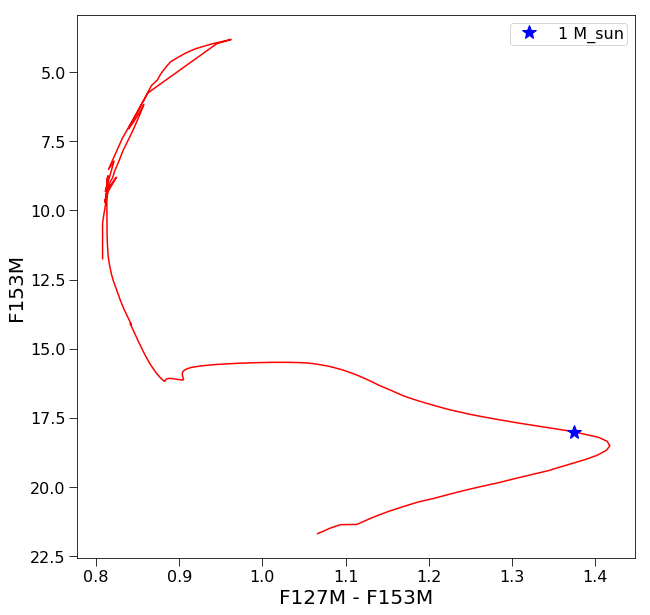

In [47]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 M_sun')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

PopStar offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can pass in a PopStar multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [48]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01
massLimits = np.array([0.08, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

## Note: there is a Kroupa_2001 IMF object in the popstar/imf.py that one could use
## to generate the Kroupa+01 IMF. However, the Kroupa_2001 IMF object contains masses
## down to 0.01 M_sun, which is beyond the lower limit of our isochrones. As a result,
## the synthetic photometry of these stars systems are non-sensical 
##
## If the user isn't interested in the photometry, then they could define the 
## IMF object as:
## my_imf = imf.Kroupa_2001(multiplicity=imf_multi)

### Step 3: Make the Cluster
To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined.

The individual star systems in the cluster and their properties are stored in an astropy table accessed by the star_systems subfunction on the cluster object. Note that the photometry of these star systems includes the contributions from all companions, which are generated probabilistically using the multiplicity defined in the IMF object.

In [49]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 42 stars out of mass range
      mass      isMultiple    systemMass   ...  m_hst_f153m  N_companions
--------------- ---------- --------------- ... ------------- ------------
 0.293456249408       True  0.556115363327 ... 19.1745154645            1
 0.190259458244      False  0.190259458244 ... 20.4691960779            0
 0.167482324466      False  0.167482324466 ... 20.6360974799            0
0.0970984170264      False 0.0970984170264 ... 21.3502364422            0
 0.268352984793      False  0.268352984793 ... 19.9752849497            0
 0.375813073596      False  0.375813073596 ... 19.4857423932            0
 0.440962288124      False  0.440962288124 ... 19.2173686131            0
 0.471549724268      False  0.471549724268 ... 19.1161271952            0
 0.577423123497      False  0.577423123497 ... 18.8151219165            0
 0.149385619665      False  0.149385619665 ... 20.7908449043            0
            ...        ...             ... ...           ...          ...
 0.14

In [50]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


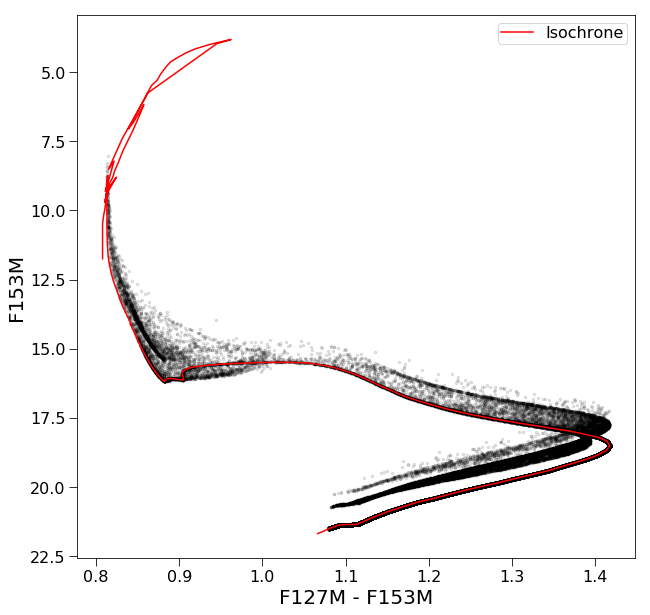

In [51]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()